# Prediction of the Price of Used Cars

The problem here is from the dataset:https://www.kaggle.com/avikasliwal/used-cars-price-prediction#train-data.csv

The challenge is the predict the price of a used car based on the features given below.
 * **Name**: The brand and model of the car.
 * **Location**: The location in which the car is being sold or is available for purchase.
 * **Year**: The year or edition of the model.
 * **Kilometers_Driven**: The total kilometres driven in the car by the previous owner(s) in KM.
 * **Fuel_Type**: The type of fuel used by the car. (Petrol / Diesel / Electric / CNG / LPG)
 * **Transmission**: The type of transmission used by the car. (Automatic / Manual)
 * **Owner_Type**: Whether the ownership is Firsthand, Second hand or other.
 * **Mileage**: The standard mileage offered by the car company in kmpl or km/kg
 * **Engine**: The displacement volume of the engine in cc.
 * **Power**: The maximum power of the engine in bhp.
 * **Seats**: The number of seats in the car.
 * **New_Price**: The price of a new car of the same model.
 * **Price**: The price of the used car in INR Lakhs.
 
In this notebook, we shall tackle the usual machine learning pipeline. 

## Importing the necessary libraries

In [1]:
# Data manipulation libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

%matplotlib inline

#Model development and feature engineering libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn import metrics

## Load the data

In [2]:
train = pd.read_csv('train-data.csv')

test = pd.read_csv('test-data.csv')

print('Train Size : {} \nTest Size : {}'.format(train.shape,test.shape) )

Train Size : (6019, 14) 
Test Size : (1234, 13)


In [3]:
combined = [train,test]

## Exploratory Data Analysis

Explore the data;Cleaning it and deriving insights from it

In [4]:
train.head()

Unnamed: 0                              Name    Location  Year  \
0           0            Maruti Wagon R LXI CNG      Mumbai  2010   
1           1  Hyundai Creta 1.6 CRDi SX Option        Pune  2015   
2           2                      Honda Jazz V     Chennai  2011   
3           3                 Maruti Ertiga VDI     Chennai  2012   
4           4   Audi A4 New 2.0 TDI Multitronic  Coimbatore  2013   

   Kilometers_Driven Fuel_Type Transmission Owner_Type     Mileage   Engine  \
0              72000       CNG       Manual      First  26.6 km/kg   998 CC   
1              41000    Diesel       Manual      First  19.67 kmpl  1582 CC   
2              46000    Petrol       Manual      First   18.2 kmpl  1199 CC   
3              87000    Diesel       Manual      First  20.77 kmpl  1248 CC   
4              40670    Diesel    Automatic     Second   15.2 kmpl  1968 CC   

       Power  Seats  New_Price  Price  
0  58.16 bhp    5.0        NaN   1.75  
1  126.2 bhp    5.0        NaN  12.50  
2   88.7 bhp    5.0  8.61 Lakh   4.50  
3  88.76 bhp    7.0        NaN   6.00  
4  140.8 bhp    5.0        NaN  17.74

In [5]:
test.head()

Unnamed: 0                                       Name    Location  Year  \
0           0                    Maruti Alto K10 LXI CNG       Delhi  2014   
1           1              Maruti Alto 800 2016-2019 LXI  Coimbatore  2013   
2           2  Toyota Innova Crysta Touring Sport 2.4 MT      Mumbai  2017   
3           3                       Toyota Etios Liva GD   Hyderabad  2012   
4           4                          Hyundai i20 Magna      Mumbai  2014   

   Kilometers_Driven Fuel_Type Transmission Owner_Type      Mileage   Engine  \
0              40929       CNG       Manual      First  32.26 km/kg   998 CC   
1              54493    Petrol       Manual     Second    24.7 kmpl   796 CC   
2              34000    Diesel       Manual      First   13.68 kmpl  2393 CC   
3             139000    Diesel       Manual      First   23.59 kmpl  1364 CC   
4              29000    Petrol       Manual      First    18.5 kmpl  1197 CC   

       Power  Seats   New_Price  
0   58.2 bhp    4.0         NaN  
1   47.3 bhp    5.0         NaN  
2  147.8 bhp    7.0  25.27 Lakh  
3   null bhp    5.0         NaN  
4  82.85 bhp    5.0         NaN

In [6]:
# info on the dataset
train.info()

print('-'*45)

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
Unnamed: 0           6019 non-null int64
Name                 6019 non-null object
Location             6019 non-null object
Year                 6019 non-null int64
Kilometers_Driven    6019 non-null int64
Fuel_Type            6019 non-null object
Transmission         6019 non-null object
Owner_Type           6019 non-null object
Mileage              6017 non-null object
Engine               5983 non-null object
Power                5983 non-null object
Seats                5977 non-null float64
New_Price            824 non-null object
Price                6019 non-null float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB
---------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234 entries, 0 to 1233
Data columns (total 13 columns):
Unnamed: 0           1234 non-null int64
Name                 1234 non-null object
Locatio

From this we can see that we have some missing values in some columns. There is also some tidying up that is necessary in some columns eg Mileage, Engine, Power and Seats.

Let's do some further exploration using pandas profile

In [7]:
ProfileReport(train)

In [8]:
ProfileReport(test)

Now, let's clean the data. Starting by dropping New price and unnamed. New price is being dropped as it has 85% missing data. For unnamed, it is because it offers no use to the data and hence will be useless in training the model

In [9]:
#dropping Unnamed and New price columns

for dataset in combined:
    dataset.drop(['Unnamed: 0','New_Price'],axis=1,inplace = True)

In [10]:
#The highly skewed km driven. 

train['Kilometers_Driven'].skew()

58.72466188582937

In [11]:
test['Kilometers_Driven'].skew()

1.6366650194795138

In [12]:
# Apply log transform and see how the skew changes
#train['Kilometers_Driven']=np.log(train['Kilometers_Driven'])

# Apply box cox
from scipy import stats

km = stats.boxcox(train['Kilometers_Driven'])[0]
train['Kilometers_Driven'] = pd.Series(km)

In [13]:
train['Kilometers_Driven'].skew()

0.32909376006638985

In [14]:
# Year to date time
for dataset in combined:
    dataset['Year']=pd.to_datetime(dataset['Year'])

Now let's manipulate some columns:

### Mileage
For mileage, we separate the SI unit from the value, rename the column and categorize the mileages

Splitting the data: https://www.geeksforgeeks.org/python-pandas-split-strings-into-two-list-columns-using-str-split/

In [15]:
# Let's split the data and change the datatype

# Train data set
new_train = train['Mileage'].str.split(' ',n = 1, expand=True)

# Test dataset
new_test = test['Mileage'].str.split(' ',n=1,expand=True)

print(new_train)

print(new_test)

          0      1
0      26.6  km/kg
1     19.67   kmpl
2      18.2   kmpl
3     20.77   kmpl
4      15.2   kmpl
...     ...    ...
6014   28.4   kmpl
6015   24.4   kmpl
6016   14.0   kmpl
6017   18.9   kmpl
6018  25.44   kmpl

[6019 rows x 2 columns]
          0      1
0     32.26  km/kg
1      24.7   kmpl
2     13.68   kmpl
3     23.59   kmpl
4      18.5   kmpl
...     ...    ...
1229  20.54   kmpl
1230  17.21   kmpl
1231  23.08   kmpl
1232   17.2   kmpl
1233   10.0   kmpl

[1234 rows x 2 columns]


In [16]:
#Change data in the column mileage
train['Mileage']=new_train[0].astype(float)

test['Mileage']=new_test[0].astype(float)

In [17]:
# Now let's categorize these column
for dataset in combined:
    dataset.loc[(dataset ['Mileage']>0 ) & (dataset['Mileage']<=10) , 'Mileage'] = 0
    dataset.loc[(dataset ['Mileage']>10 ) & (dataset['Mileage']<=20) , 'Mileage'] = 1
    dataset.loc[(dataset ['Mileage']>20 ) & (dataset['Mileage']<=30) , 'Mileage'] = 2
    dataset.loc[(dataset ['Mileage']>30 ),'Mileage']=3
    

### Engine
In this column, let us separate the cc from the number and leave the numerical value.Then categorize the values in order to reduce the cardinality

In [18]:
#Splitting the values
#Train set
engine_new = train['Engine'].str.split(" ", n = 1 , expand = True)

#Test
engine_newer = test['Engine'].str.split(" ", n = 1 , expand = True)

In [19]:
#Replace the values in the engine column
train['Engine']= engine_new[0]

test['Engine']= engine_newer[0]



In [20]:
train['Engine'].isnull().sum()

36

In [21]:
# Position of missing values in train

train.loc[np.nonzero(pd.isnull(train['Engine']))]

Name    Location  \
194                             Honda City 1.5 GXI   Ahmedabad   
208                           Maruti Swift 1.3 VXi     Kolkata   
733                           Maruti Swift 1.3 VXi     Chennai   
749                   Land Rover Range Rover 3.0 D      Mumbai   
1294                             Honda City 1.3 DX       Delhi   
1327                          Maruti Swift 1.3 ZXI   Hyderabad   
1385                            Honda City 1.5 GXI        Pune   
1460  Land Rover Range Rover Sport 2005 2012 Sport  Coimbatore   
2074                          Maruti Swift 1.3 LXI        Pune   
2096                     Hyundai Santro LP zipPlus  Coimbatore   
2264                           Toyota Etios Liva V        Pune   
2325                      Maruti Swift 1.3 VXI ABS        Pune   
2335                          Maruti Swift 1.3 VXi      Mumbai   
2530                       BMW 5 Series 520d Sedan       Kochi   
2542               Hyundai Santro GLS II - Euro II   Bangalore   
2623                       BMW 5 Series 520d Sedan        Pune   
2668                          Maruti Swift 1.3 VXi     Kolkata   
2737                             Maruti Wagon R Vx      Jaipur   
2780               Hyundai Santro GLS II - Euro II        Pune   
2842               Hyundai Santro GLS II - Euro II   Bangalore   
3272                       BMW 5 Series 520d Sedan      Mumbai   
3404                          Maruti Swift 1.3 VXi      Jaipur   
3520                       BMW 5 Series 520d Sedan       Delhi   
3522               Hyundai Santro GLS II - Euro II       Kochi   
3810                   Honda CR-V AT With Sun Roof     Kolkata   
4011                        Fiat Punto 1.3 Emotion        Pune   
4152                  Land Rover Range Rover 3.0 D      Mumbai   
4229                        Hyundai Santro Xing XG   Bangalore   
4577                       BMW 5 Series 520d Sedan       Delhi   
4604                     Honda Jazz Select Edition        Pune   
4697                        Fiat Punto 1.2 Dynamic       Kochi   
4712                        Hyundai Santro Xing XG        Pune   
4952                        Fiat Punto 1.4 Emotion     Kolkata   
5015                          Maruti Swift 1.3 VXi       Delhi   
5185                          Maruti Swift 1.3 LXI       Delhi   
5270                            Honda City 1.5 GXI   Bangalore   

                              Year  Kilometers_Driven Fuel_Type Transmission  \
194  1970-01-01 00:00:00.000002007          68.115237    Petrol       Manual   
208  1970-01-01 00:00:00.000002010          61.537158    Petrol       Manual   
733  1970-01-01 00:00:00.000002006          78.211033    Petrol       Manual   
749  1970-01-01 00:00:00.000002008          66.450576    Diesel    Automatic   
1294 1970-01-01 00:00:00.000002009          66.451950    Petrol       Manual   
1327 1970-01-01 00:00:00.000002015          64.781098    Petrol       Manual   
1385 1970-01-01 00:00:00.000002004          81.863442    Petrol       Manual   
1460 1970-01-01 00:00:00.000002008          70.890202    Petrol       Manual   
2074 1970-01-01 00:00:00.000002011          52.570425    Petrol       Manual   
2096 1970-01-01 00:00:00.000002004          65.450838    Petrol       Manual   
2264 1970-01-01 00:00:00.000002012          52.722929    Petrol       Manual   
2325 1970-01-01 00:00:00.000002015          70.279229    Petrol       Manual   
2335 1970-01-01 00:00:00.000002007          66.450233    Petrol       Manual   
2530 1970-01-01 00:00:00.000002014          69.420789    Diesel    Automatic   
2542 1970-01-01 00:00:00.000002011          69.677968    Petrol       Manual   
2623 1970-01-01 00:00:00.000002012          77.572839    Diesel    Automatic   
2668 1970-01-01 00:00:00.000002014          57.427769    Petrol       Manual   
2737 1970-01-01 00:00:00.000002001          95.612161    Petrol       Manual   
2780 1970-01-01 00:00:00.000002009          78.703168    Petrol       Manual   
284

In [22]:
test['Engine'].isnull().sum()


10

In [23]:
#drop missing values
for dataset in combined:
    dataset.dropna(how='any', inplace=True)
    

In [24]:
test.isnull().sum()

Name                 0
Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
dtype: int64

In [25]:
train.shape

(5975, 12)

In [26]:
test.shape

(1223, 11)

In [27]:
test.sample(6)

Name    Location  \
945                 Mercedes-Benz GLE 350d   Hyderabad   
492  Toyota Innova 2.5 G (Diesel) 7 Seater  Coimbatore   
630                 Maruti Swift Dzire VDi       Delhi   
699                BMW 3 Series 320d Sport  Coimbatore   
73         Tata Tiago AMT 1.2 Revotron XTA      Mumbai   
351        Maruti Vitara Brezza VDi Option       Delhi   

                             Year  Kilometers_Driven Fuel_Type Transmission  \
945 1970-01-01 00:00:00.000002016              50000    Diesel    Automatic   
492 1970-01-01 00:00:00.000002015              54278    Diesel       Manual   
630 1970-01-01 00:00:00.000002010              68000    Diesel       Manual   
699 1970-01-01 00:00:00.000002017              41078    Diesel    Automatic   
73  1970-01-01 00:00:00.000002017              14000    Petrol    Automatic   
351 1970-01-01 00:00:00.000002016              66000    Diesel       Manual   

    Owner_Type  Mileage Engine       Power  Seats  
945      First      1.0   2987  254.79 bhp    5.0  
492      First      1.0   2494   100.6 bhp    7.0  
630      First      1.0   1248    73.9 bhp    5.0  
699      First      2.0   1995     190 bhp    5.0  
73       First      2.0   1199      84 bhp    5.0  
351      First      2.0   1248    88.5 bhp    5.0

In [28]:
#Change values to int
for dataset in combined:
    dataset['Engine']=dataset['Engine'].astype(np.int64)

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5975 entries, 0 to 6018
Data columns (total 12 columns):
Name                 5975 non-null object
Location             5975 non-null object
Year                 5975 non-null datetime64[ns]
Kilometers_Driven    5975 non-null float64
Fuel_Type            5975 non-null object
Transmission         5975 non-null object
Owner_Type           5975 non-null object
Mileage              5975 non-null float64
Engine               5975 non-null int64
Power                5975 non-null object
Seats                5975 non-null float64
Price                5975 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1), object(6)
memory usage: 606.8+ KB


In [30]:
# Let's categorize the values
for dataset in combined:
    dataset.loc[(dataset['Engine']<=1000 ),'Engine']=0
    dataset.loc[(dataset['Engine']>1000 ) & (dataset['Engine']<=2000) , 'Engine'] = 1
    dataset.loc[(dataset['Engine']>2000 ) & (dataset['Engine']<=3000) , 'Engine'] = 2
    dataset.loc[(dataset['Engine']>3000 ),'Engine']=3
    

In [31]:
test.sample(6)

Name    Location  \
416          Honda City i DTec VX Option BL  Coimbatore   
328                         Maruti Ritz LDi     Chennai   
127         BMW 3 Series GT 320d Sport Line   Hyderabad   
676                    Honda Brio 1.2 VX MT       Kochi   
688                       Hyundai i10 Magna     Chennai   
494  Audi A6 2011-2015 2.0 TDI Premium Plus   Bangalore   

                             Year  Kilometers_Driven Fuel_Type Transmission  \
416 1970-01-01 00:00:00.000002017              48184    Diesel       Manual   
328 1970-01-01 00:00:00.000002016             131503    Diesel       Manual   
127 1970-01-01 00:00:00.000002015              40000    Diesel    Automatic   
676 1970-01-01 00:00:00.000002014              43814    Petrol       Manual   
688 1970-01-01 00:00:00.000002007              73000    Petrol       Manual   
494 1970-01-01 00:00:00.000002013              40000    Diesel    Automatic   

    Owner_Type  Mileage  Engine       Power  Seats  
416      First      2.0       1    98.6 bhp    5.0  
328      First      2.0       1   73.94 bhp    5.0  
127      First      1.0       1     184 bhp    5.0  
676      First      1.0       1    86.8 bhp    5.0  
688      First      2.0       1    78.9 bhp    5.0  
494      First      1.0       1  174.33 bhp    5.0

### Power
We do the same as we did for engine

In [32]:
# Split the data
#train

power_train = train['Power'].str.split(' ', n = 1,expand = True)

#Test
power_test = test['Power'].str.split(' ', n = 1,expand = True)

In [33]:
train['Power']= power_train[0]

test['Power']=power_test[0]

In [34]:
#Length of null values

len(train[train['Power']=='null'])


103

In [35]:
#Length of null values

len(test[test['Power']=='null'])

22

In [36]:
# Dealing with these null values. We label them as unknown and give them a value of zero
for dataset in combined:
    dataset['Power'].replace({'null':'0'}, inplace=True)


In [37]:
# Change values to float
for dataset in combined:
    dataset['Power']=dataset['Power'].astype(float)

In [38]:
#Categorize the data
for dataset in combined:
    dataset.loc[(dataset ['Power']>0 ) & (dataset['Power']<=50) , 'Power'] = 1
    dataset.loc[(dataset ['Power']>50 ) & (dataset['Power']<=100) , 'Power'] = 2
    dataset.loc[(dataset ['Power']>100 ),'Power']=3
    

In [39]:
## View the data

train.head()

Name    Location                          Year  \
0            Maruti Wagon R LXI CNG      Mumbai 1970-01-01 00:00:00.000002010   
1  Hyundai Creta 1.6 CRDi SX Option        Pune 1970-01-01 00:00:00.000002015   
2                      Honda Jazz V     Chennai 1970-01-01 00:00:00.000002011   
3                 Maruti Ertiga VDI     Chennai 1970-01-01 00:00:00.000002012   
4   Audi A4 New 2.0 TDI Multitronic  Coimbatore 1970-01-01 00:00:00.000002013   

   Kilometers_Driven Fuel_Type Transmission Owner_Type  Mileage  Engine  \
0          71.727004       CNG       Manual      First      2.0       0   
1          61.114778    Diesel       Manual      First      1.0       1   
2          63.154609    Petrol       Manual      First      1.0       1   
3          75.670281    Diesel       Manual      First      2.0       1   
4          60.973881    Diesel    Automatic     Second      1.0       1   

   Power  Seats  Price  
0    2.0    5.0   1.75  
1    3.0    5.0  12.50  
2    2.0    5.0   4.50  
3    2.0    7.0   6.00  
4    3.0    5.0  17.74

In [40]:
test.sample(6)

Name    Location  \
205            Chevrolet Beat Diesel LS  Coimbatore   
595                Honda Brio 1.2 VX MT   Hyderabad   
738   Toyota Innova Crysta 2.8 GX AT 8S      Mumbai   
742                    Maruti Swift VDI       Kochi   
1014        Hyundai i20 1.4 CRDi Sportz   Ahmedabad   
878                  Maruti Wagon R VXI     Chennai   

                              Year  Kilometers_Driven Fuel_Type Transmission  \
205  1970-01-01 00:00:00.000002016              68673    Diesel       Manual   
595  1970-01-01 00:00:00.000002012              41000    Petrol       Manual   
738  1970-01-01 00:00:00.000002018              23000    Diesel    Automatic   
742  1970-01-01 00:00:00.000002015              58634    Diesel       Manual   
1014 1970-01-01 00:00:00.000002011              62000    Diesel       Manual   
878  1970-01-01 00:00:00.000002010              36000    Petrol       Manual   

     Owner_Type  Mileage  Engine  Power  Seats  
205       First      2.0       0    2.0    5.0  
595       First      1.0       1    2.0    5.0  
738       First      1.0       2    3.0    8.0  
742       First      2.0       1    2.0    5.0  
1014      First      2.0       1    2.0    5.0  
878      Second      2.0       0    2.0    5.0

### Name

In [41]:
#split

#Train
name_train = train['Name'].str.split(' ',n = 1, expand = True)

# Test
name_test =test['Name'].str.split(' ',n = 1, expand = True)

In [42]:
name_train.sample(6)

0                                      1
5791  Mercedes-Benz  E-Class 2015-2017 E250 CDI Avantgarde
347         Hyundai                        EON D Lite Plus
125        Mahindra                            Scorpio VLX
3278       Mahindra                          XUV500 W8 4WD
4811       Mahindra                              Thar CRDe
5220        Hyundai                 i20 Magna Optional 1.2

In [43]:
#Change the data in Name
train['Name']=name_train[0]

test['Name']=name_test[0]

In [44]:
train.head()

Name    Location                          Year  Kilometers_Driven  \
0   Maruti      Mumbai 1970-01-01 00:00:00.000002010          71.727004   
1  Hyundai        Pune 1970-01-01 00:00:00.000002015          61.114778   
2    Honda     Chennai 1970-01-01 00:00:00.000002011          63.154609   
3   Maruti     Chennai 1970-01-01 00:00:00.000002012          75.670281   
4     Audi  Coimbatore 1970-01-01 00:00:00.000002013          60.973881   

  Fuel_Type Transmission Owner_Type  Mileage  Engine  Power  Seats  Price  
0       CNG       Manual      First      2.0       0    2.0    5.0   1.75  
1    Diesel       Manual      First      1.0       1    3.0    5.0  12.50  
2    Petrol       Manual      First      1.0       1    2.0    5.0   4.50  
3    Diesel       Manual      First      2.0       1    2.0    7.0   6.00  
4    Diesel    Automatic     Second      1.0       1    3.0    5.0  17.74

In [45]:
train.Name.value_counts()

Maruti           1197
Hyundai          1100
Honda             601
Toyota            409
Mercedes-Benz     318
Volkswagen        315
Ford              298
Mahindra          271
BMW               262
Audi              236
Tata              186
Skoda             173
Renault           145
Chevrolet         121
Nissan             91
Land               57
Jaguar             40
Mitsubishi         27
Mini               26
Fiat               25
Volvo              21
Porsche            18
Jeep               15
Datsun             13
Force               3
ISUZU               2
Bentley             1
Lamborghini         1
Isuzu               1
Smart               1
Ambassador          1
Name: Name, dtype: int64

In [46]:
# Categorize the data
for dataset in combined:
    for x in dataset['Name']:
        if (x !='Maruti') and (x!='Hyundai') and (x!='Honda') and (x !='Toyota') and (x !='Mercedes-Benz'):
            dataset['Name'].replace(x,'Other', inplace= True)  

            
            

In [47]:
train.head()

Name    Location                          Year  Kilometers_Driven  \
0   Maruti      Mumbai 1970-01-01 00:00:00.000002010          71.727004   
1  Hyundai        Pune 1970-01-01 00:00:00.000002015          61.114778   
2    Honda     Chennai 1970-01-01 00:00:00.000002011          63.154609   
3   Maruti     Chennai 1970-01-01 00:00:00.000002012          75.670281   
4    Other  Coimbatore 1970-01-01 00:00:00.000002013          60.973881   

  Fuel_Type Transmission Owner_Type  Mileage  Engine  Power  Seats  Price  
0       CNG       Manual      First      2.0       0    2.0    5.0   1.75  
1    Diesel       Manual      First      1.0       1    3.0    5.0  12.50  
2    Petrol       Manual      First      1.0       1    2.0    5.0   4.50  
3    Diesel       Manual      First      2.0       1    2.0    7.0   6.00  
4    Diesel    Automatic     Second      1.0       1    3.0    5.0  17.74

In [48]:
# Extract year from that column

train['Year'] = pd.DatetimeIndex(train['Year']).year

test['Year'] = pd.DatetimeIndex(test['Year']).year

In [49]:
train.head()

Name    Location  Year  Kilometers_Driven Fuel_Type Transmission  \
0   Maruti      Mumbai  1970          71.727004       CNG       Manual   
1  Hyundai        Pune  1970          61.114778    Diesel       Manual   
2    Honda     Chennai  1970          63.154609    Petrol       Manual   
3   Maruti     Chennai  1970          75.670281    Diesel       Manual   
4    Other  Coimbatore  1970          60.973881    Diesel    Automatic   

  Owner_Type  Mileage  Engine  Power  Seats  Price  
0      First      2.0       0    2.0    5.0   1.75  
1      First      1.0       1    3.0    5.0  12.50  
2      First      1.0       1    2.0    5.0   4.50  
3      First      2.0       1    2.0    7.0   6.00  
4     Second      1.0       1    3.0    5.0  17.74

In [50]:
train.Year.value_counts()

1970    5975
Name: Year, dtype: int64

## Data Visualization

Let's draw some insights from the data


In [51]:
sns.set(rc={'figure.figsize':(20, 15)})

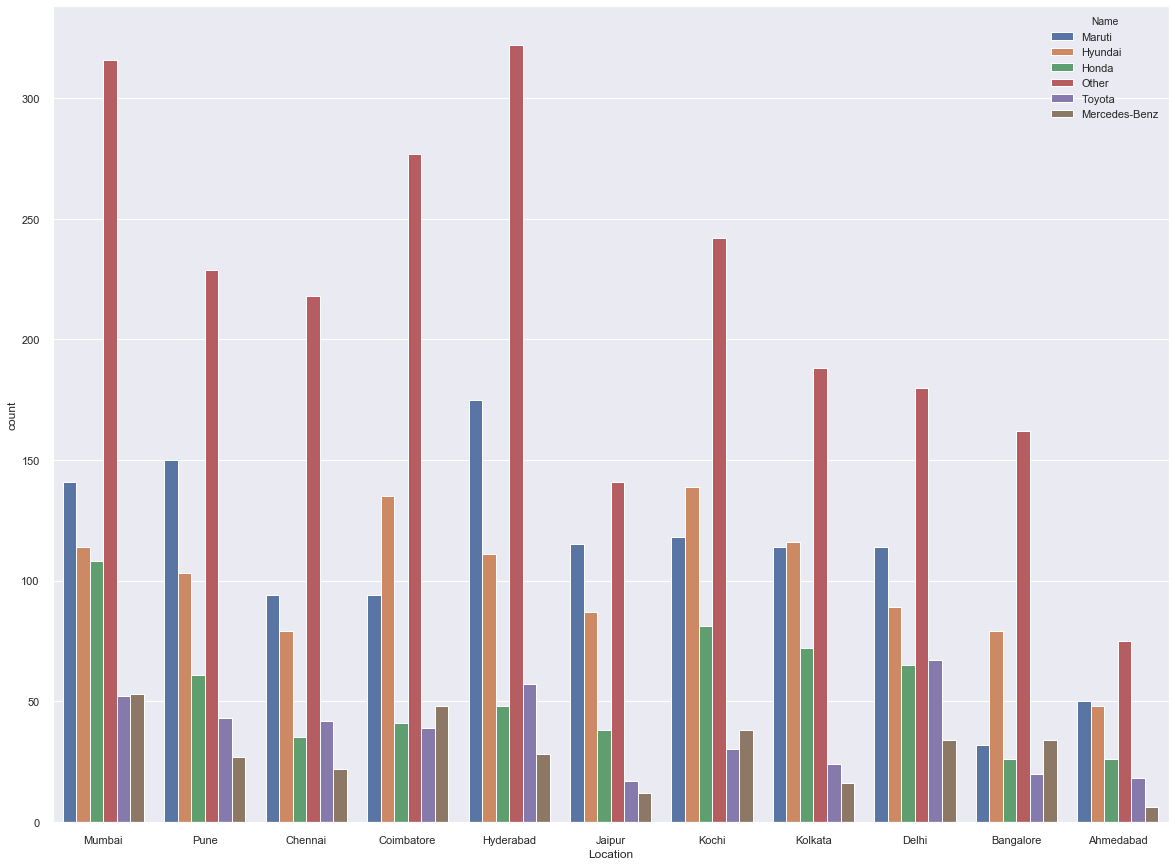

In [52]:
sns.countplot('Location', hue = 'Name', data = train)

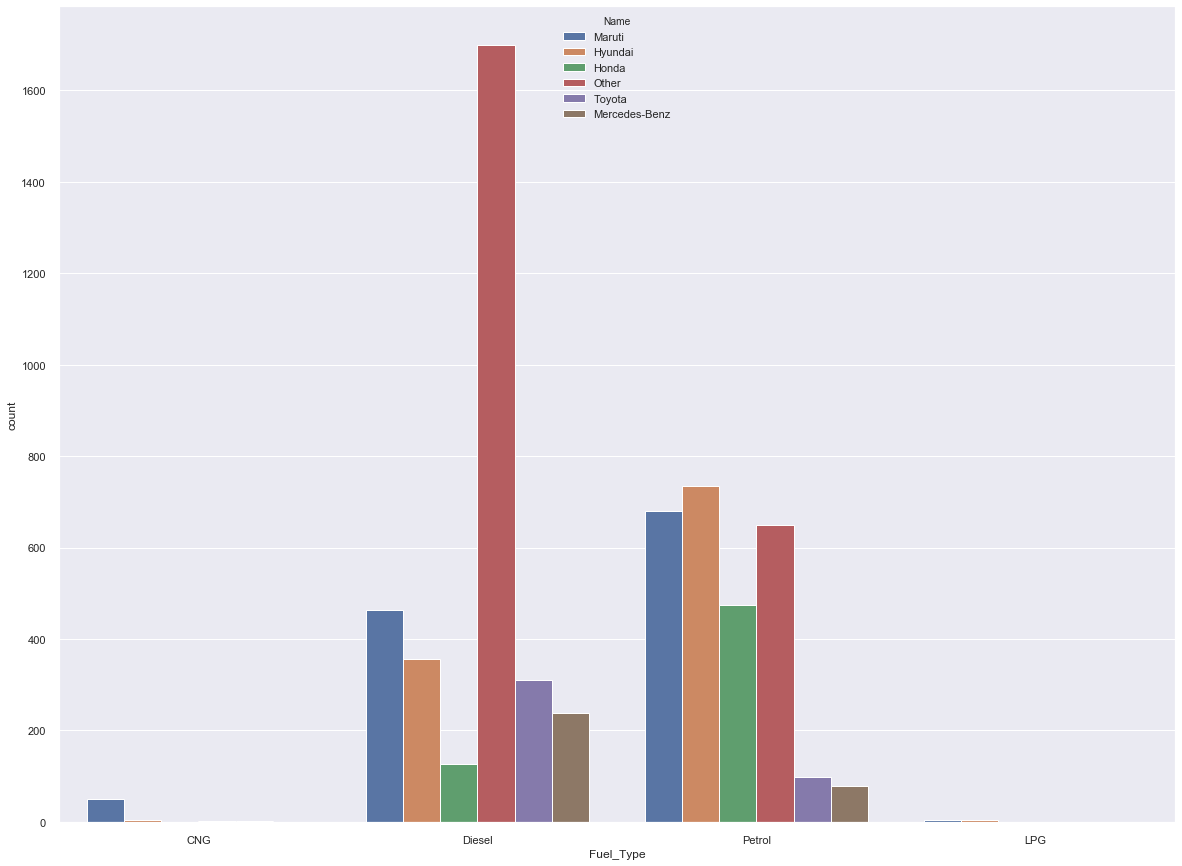

In [53]:
sns.countplot('Fuel_Type', hue = 'Name', data = train)

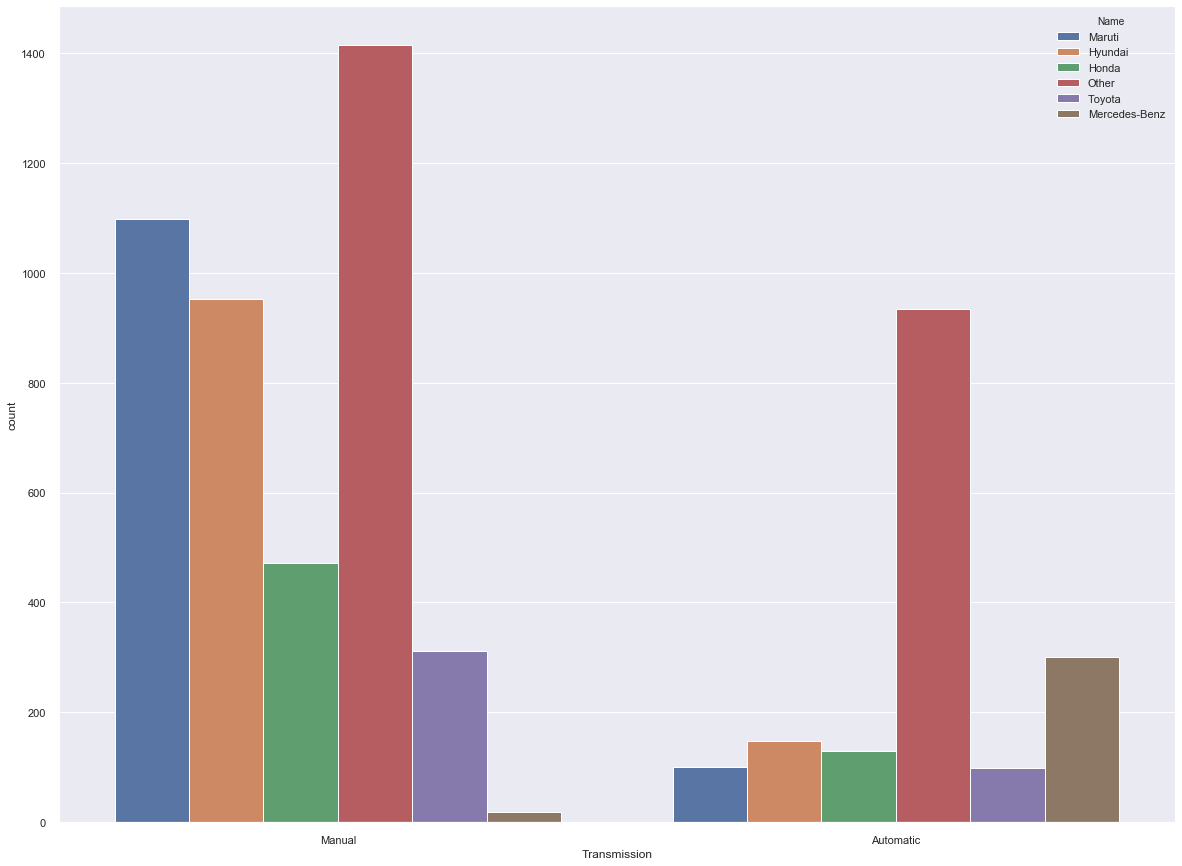

In [54]:
sns.countplot('Transmission', hue = 'Name', data = train)

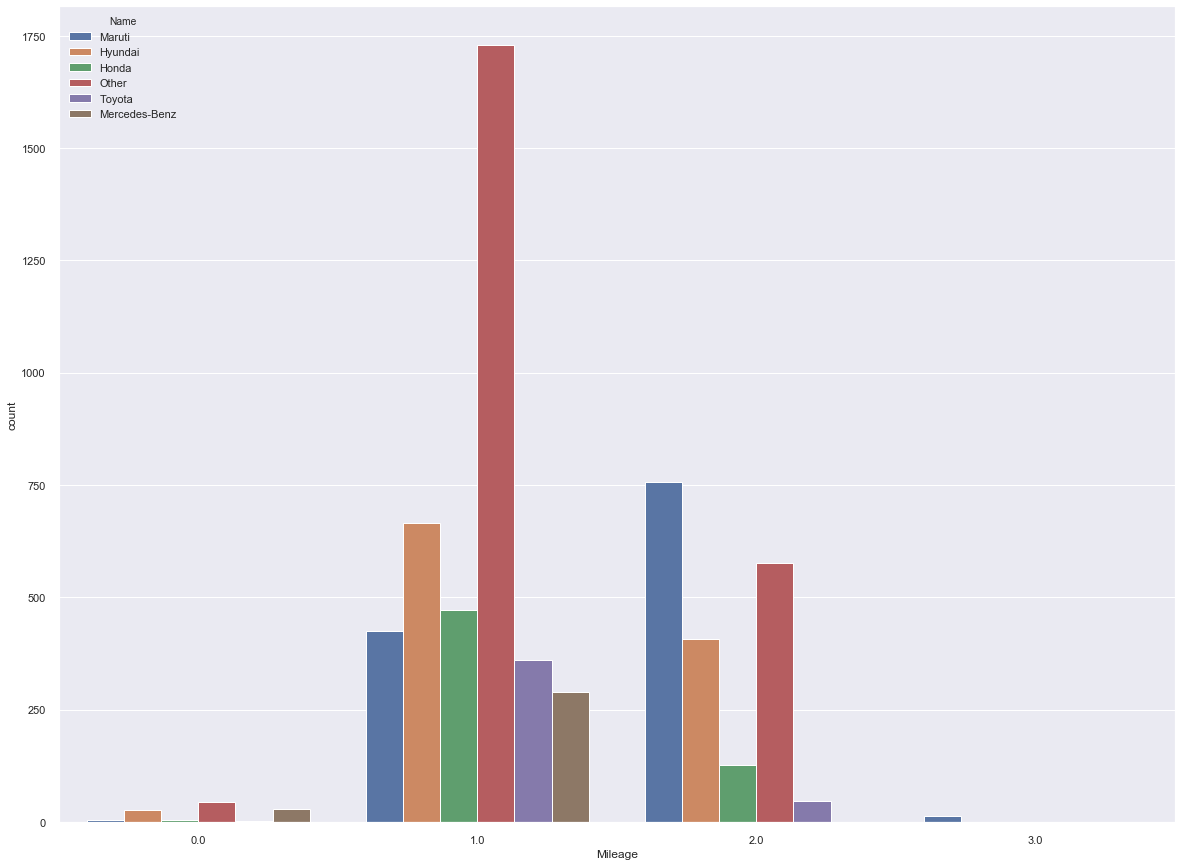

In [55]:
sns.countplot('Mileage', hue = 'Name', data = train)

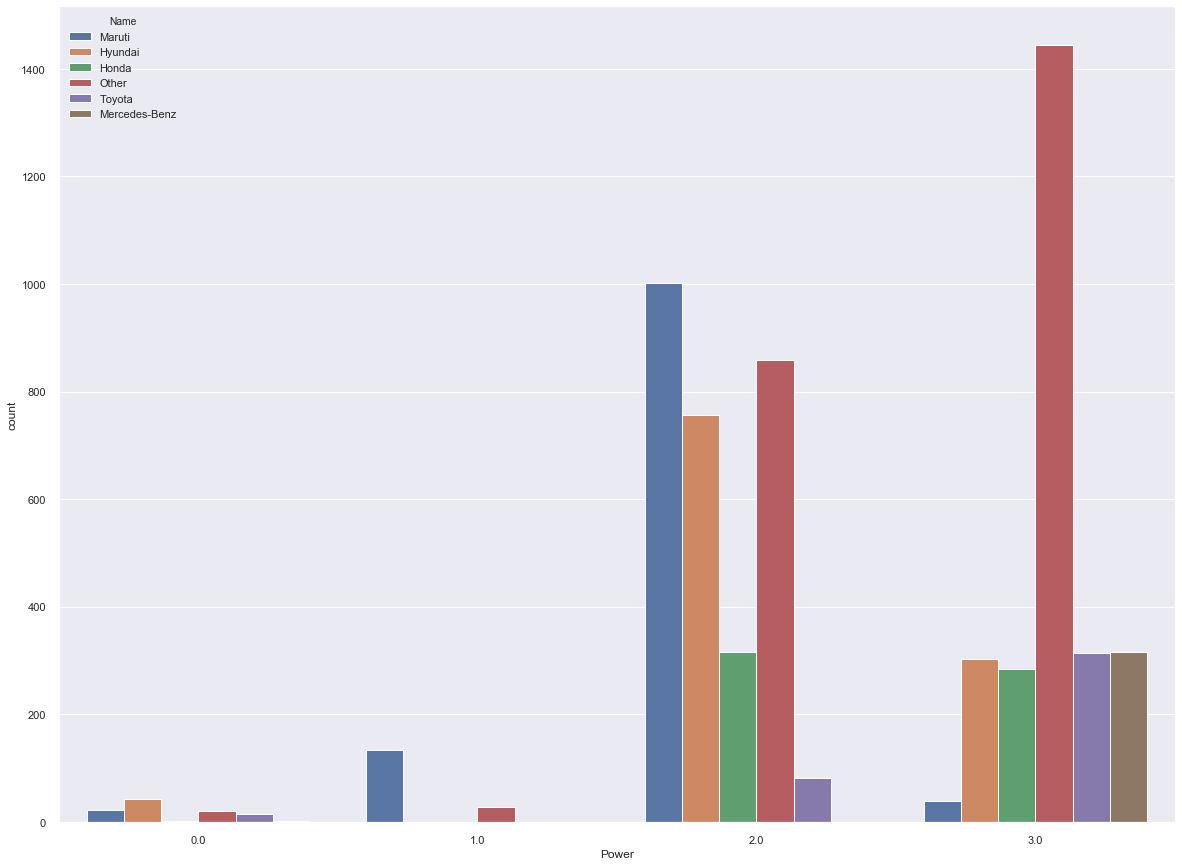

In [56]:
sns.countplot('Power', hue = 'Name', data = train)

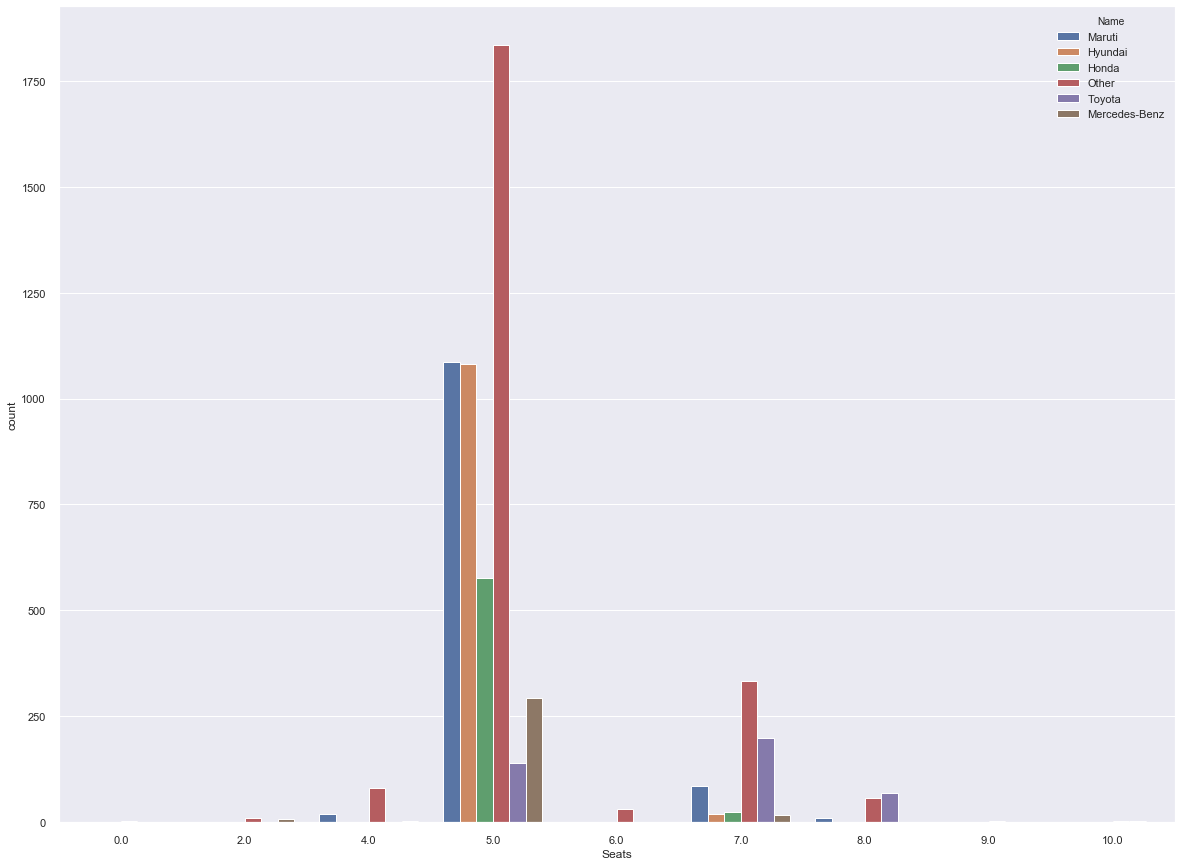

In [57]:
sns.countplot('Seats', hue = 'Name', data = train)

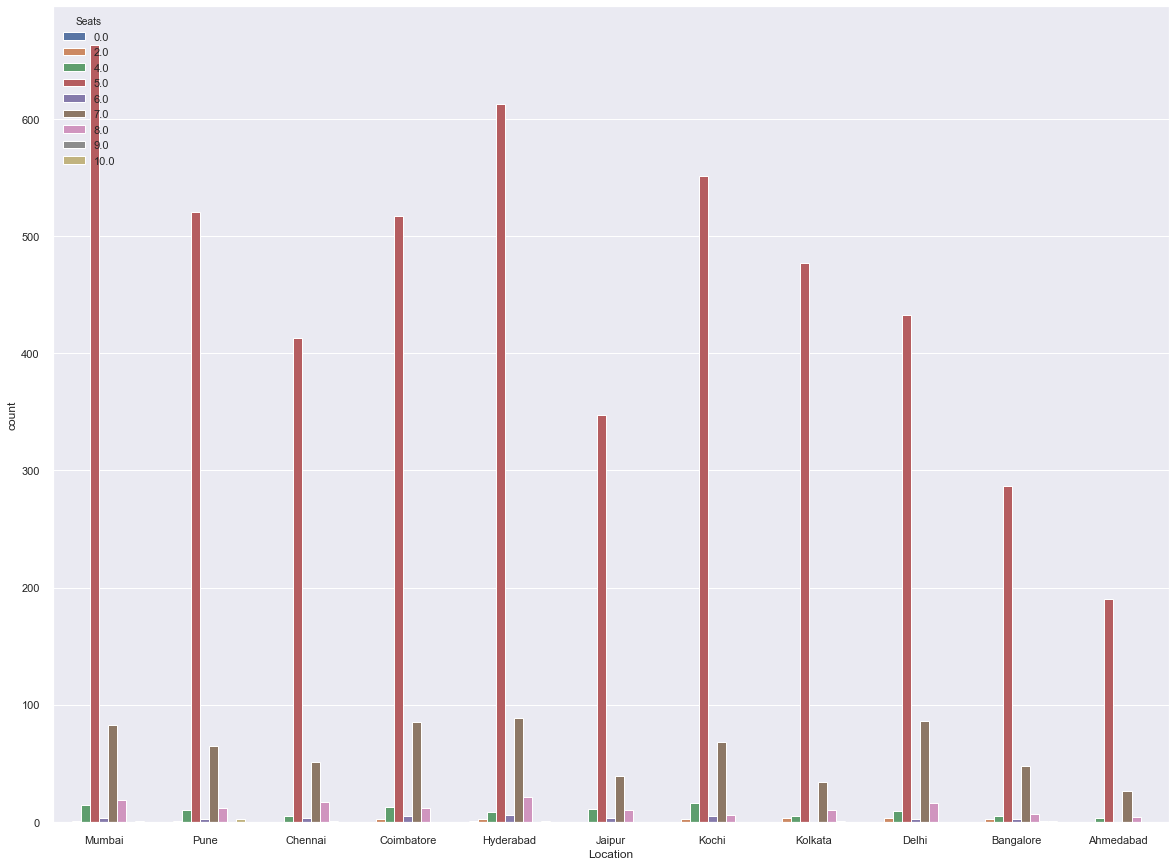

In [58]:
sns.countplot('Location', hue = 'Seats', data = train)

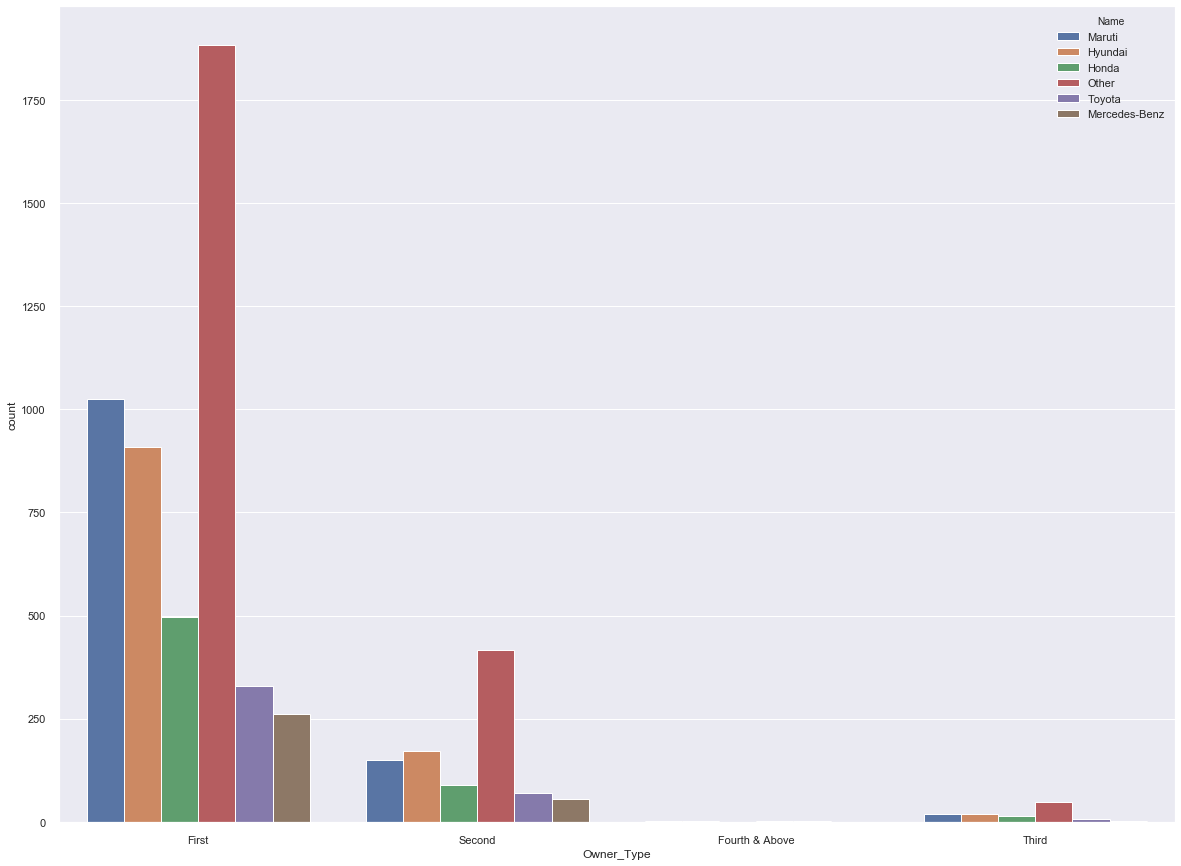

In [59]:
sns.countplot('Owner_Type', hue = 'Name', data = train)

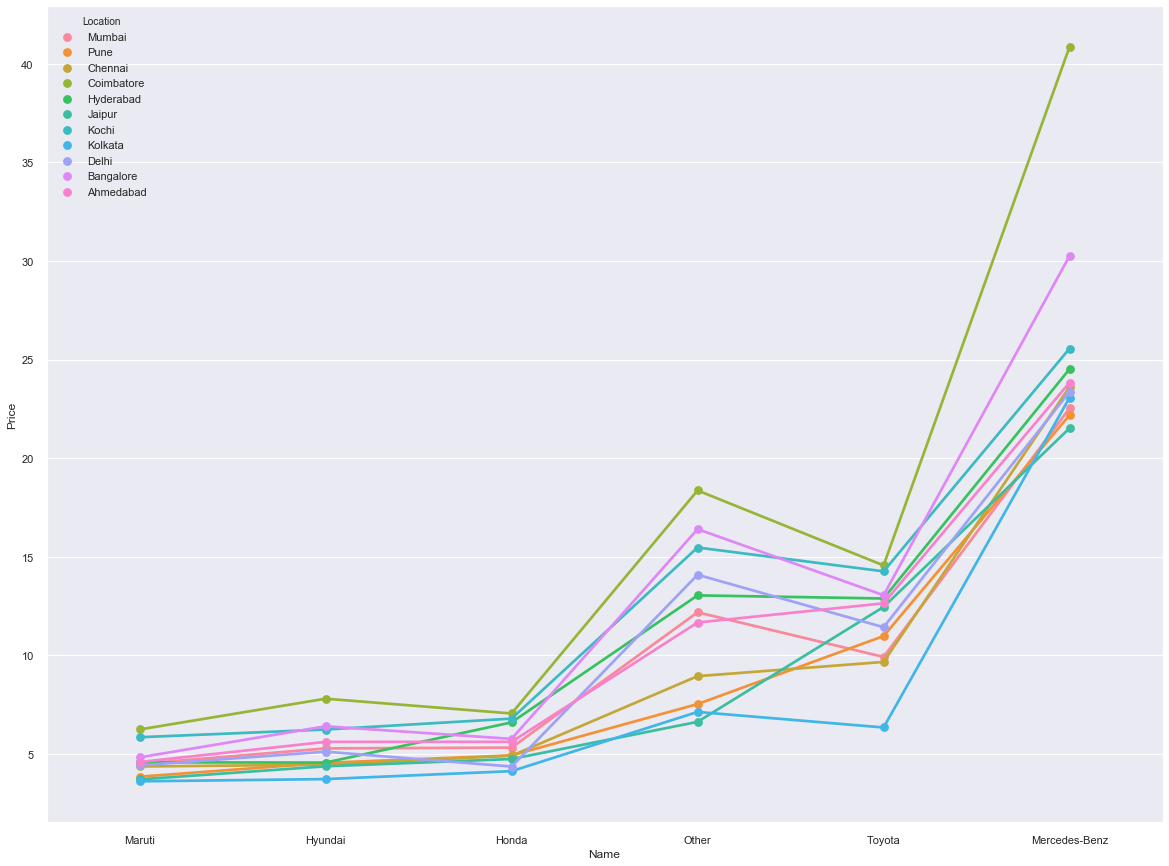

In [60]:
ax = sns.pointplot(x='Name', y='Price', hue='Location', ci=None, data=train)

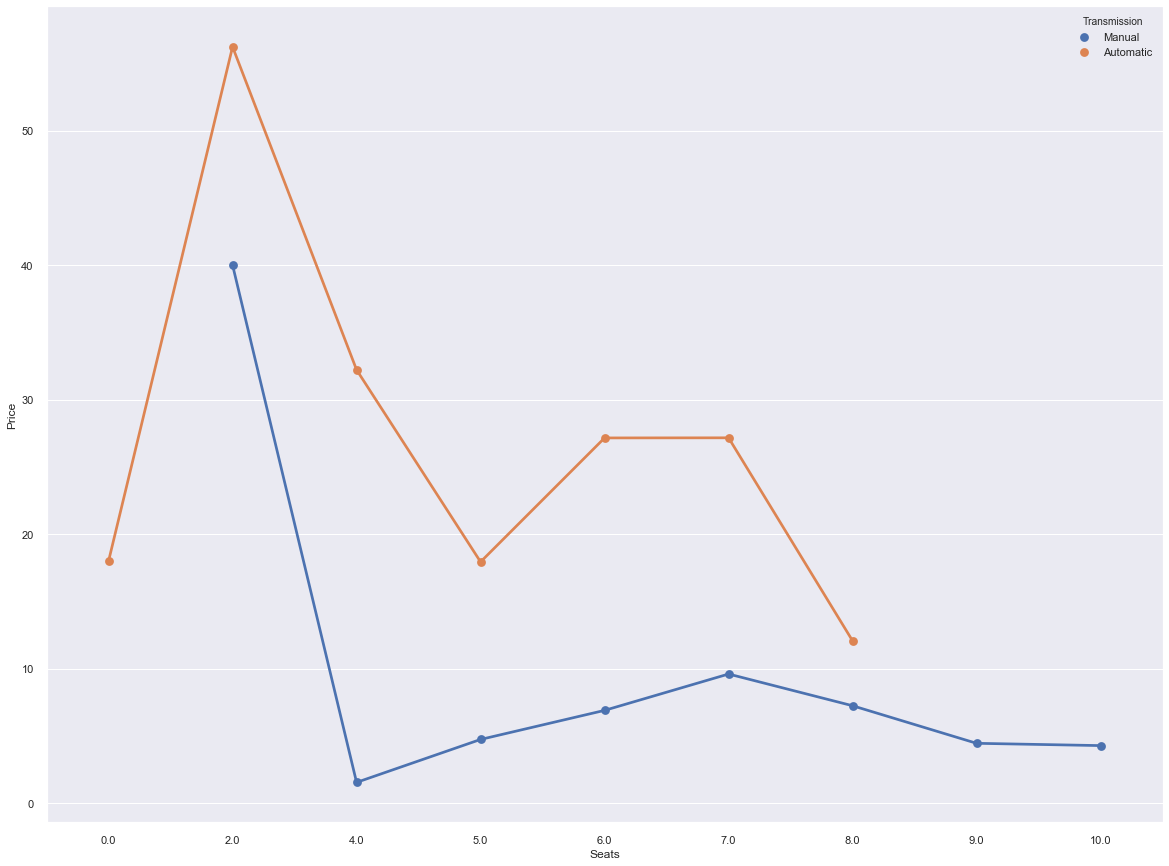

In [61]:
ax = sns.pointplot(x='Seats', y='Price', hue='Transmission', ci=None, data=train)

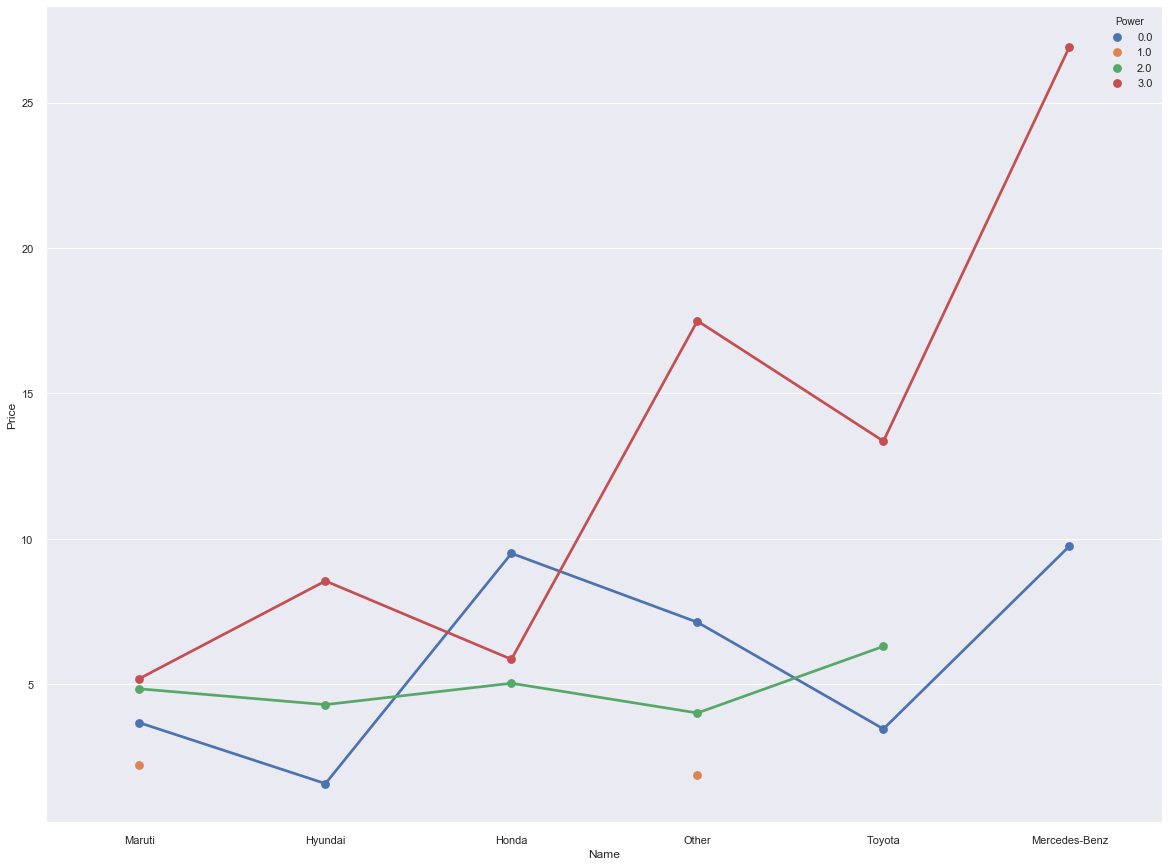

In [62]:
ax = sns.pointplot(x='Name', y='Price', hue='Power', ci=None, data=train)

#### Insights Drawn
* In all the locations, other type of cars were bought the most followed by Maruti. However, in some locations, Hyundai was       bought the most. Mainly because they are the cheapest cars you can find.

* Petrol cars were more common.

* Manual cars were more common and were cheaper. This was true for all categories except for the Mercedez Benz which was mostly   automatic.

* Mid range cars in respect to power were mostly bought.

* Cars with 5 seats were mostly bought.

* Cheapest place to buy a car was Kolkata and the most expensive is Coimbatore 

## Feature Engineering

In [63]:
train.head()

Name    Location  Year  Kilometers_Driven Fuel_Type Transmission  \
0   Maruti      Mumbai  1970          71.727004       CNG       Manual   
1  Hyundai        Pune  1970          61.114778    Diesel       Manual   
2    Honda     Chennai  1970          63.154609    Petrol       Manual   
3   Maruti     Chennai  1970          75.670281    Diesel       Manual   
4    Other  Coimbatore  1970          60.973881    Diesel    Automatic   

  Owner_Type  Mileage  Engine  Power  Seats  Price  
0      First      2.0       0    2.0    5.0   1.75  
1      First      1.0       1    3.0    5.0  12.50  
2      First      1.0       1    2.0    5.0   4.50  
3      First      2.0       1    2.0    7.0   6.00  
4     Second      1.0       1    3.0    5.0  17.74

In [64]:
# Scale the data
#from sklearn.preprocessing import StandardScaler

#StandardScaler.fit()

In [65]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for dataset in combined:
    dataset['Name']=le.fit_transform(dataset['Name'])
    dataset['Fuel_Type']=le.fit_transform(dataset['Fuel_Type'])
    dataset['Transmission']=le.fit_transform(dataset['Transmission'])
    dataset['Owner_Type']=le.fit_transform(dataset['Owner_Type'])
    dataset['Location']=le.fit_transform(dataset['Location'])

In [66]:
train.head()

Name  Location  Year  Kilometers_Driven  Fuel_Type  Transmission  \
0     2         9  1970          71.727004          0             1   
1     1        10  1970          61.114778          1             1   
2     0         2  1970          63.154609          3             1   
3     2         2  1970          75.670281          1             1   
4     4         3  1970          60.973881          1             0   

   Owner_Type  Mileage  Engine  Power  Seats  Price  
0           0      2.0       0    2.0    5.0   1.75  
1           0      1.0       1    3.0    5.0  12.50  
2           0      1.0       1    2.0    5.0   4.50  
3           0      2.0       1    2.0    7.0   6.00  
4           2      1.0       1    3.0    5.0  17.74

In [67]:
test.head()

Name  Location  Year  Kilometers_Driven  Fuel_Type  Transmission  \
0     2         4  1970              40929          0             1   
1     2         3  1970              54493          3             1   
2     5         9  1970              34000          1             1   
3     5         5  1970             139000          1             1   
4     1         9  1970              29000          3             1   

   Owner_Type  Mileage  Engine  Power  Seats  
0           0      3.0       0    2.0    4.0  
1           2      2.0       0    1.0    5.0  
2           0      1.0       2    3.0    7.0  
3           0      2.0       1    0.0    5.0  
4           0      1.0       1    2.0    5.0

In [68]:
for dataset in combined:
    dataset['Mileage'] = dataset['Mileage'].astype(int)
    dataset['Power'] = dataset['Power'].astype(int)
    dataset['Seats'] = dataset['Seats'].astype(int)
    

In [69]:
test.head()

Name  Location  Year  Kilometers_Driven  Fuel_Type  Transmission  \
0     2         4  1970              40929          0             1   
1     2         3  1970              54493          3             1   
2     5         9  1970              34000          1             1   
3     5         5  1970             139000          1             1   
4     1         9  1970              29000          3             1   

   Owner_Type  Mileage  Engine  Power  Seats  
0           0        3       0      2      4  
1           2        2       0      1      5  
2           0        1       2      3      7  
3           0        2       1      0      5  
4           0        1       1      2      5

In [70]:
train.head()

Name  Location  Year  Kilometers_Driven  Fuel_Type  Transmission  \
0     2         9  1970          71.727004          0             1   
1     1        10  1970          61.114778          1             1   
2     0         2  1970          63.154609          3             1   
3     2         2  1970          75.670281          1             1   
4     4         3  1970          60.973881          1             0   

   Owner_Type  Mileage  Engine  Power  Seats  Price  
0           0        2       0      2      5   1.75  
1           0        1       1      3      5  12.50  
2           0        1       1      2      5   4.50  
3           0        2       1      2      7   6.00  
4           2        1       1      3      5  17.74

In [71]:
for dataset in combined:
    dataset.drop('Year', axis = 1, inplace =True)

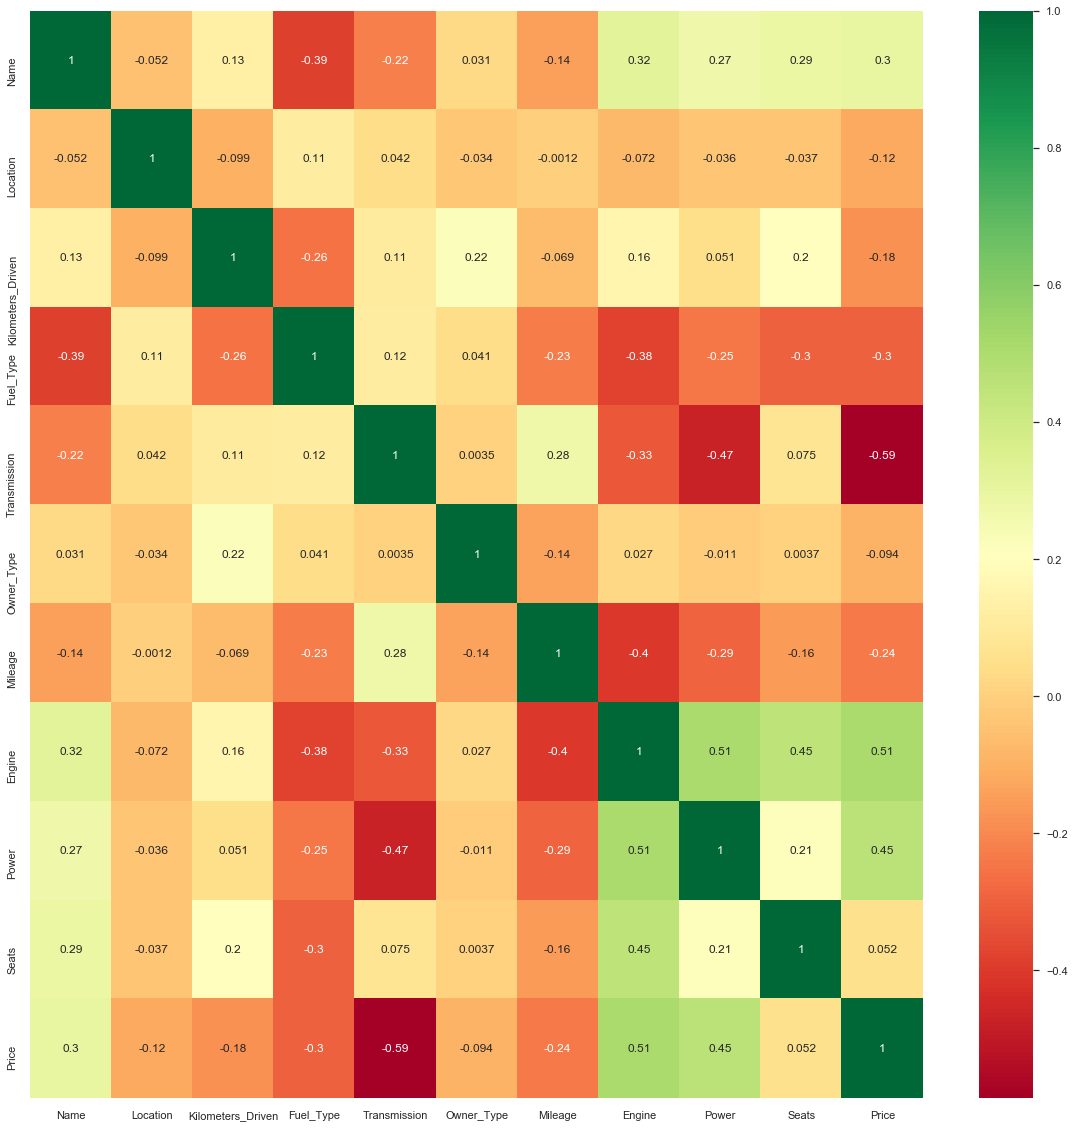

In [72]:
# Correlation Matrix
x = train.iloc[:,-1:]  #independent columns
y = train.iloc[:,-1]    #target column i.e price range
#get correlations of each features in dataset
corrmat = train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Model Development

In [73]:
x = train.drop(['Price','Name','Location'], axis = 1)
y = train['Price']

In [74]:
# Scale the data
#from sklearn.preprocessing import StandardScaler

#ss = StandardScaler()
#ss.fit(x)
#x = ss.transform(x)


In [75]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state= 7)

rmse :  8.422901928683416
R2 Score:  0.47485327289068024


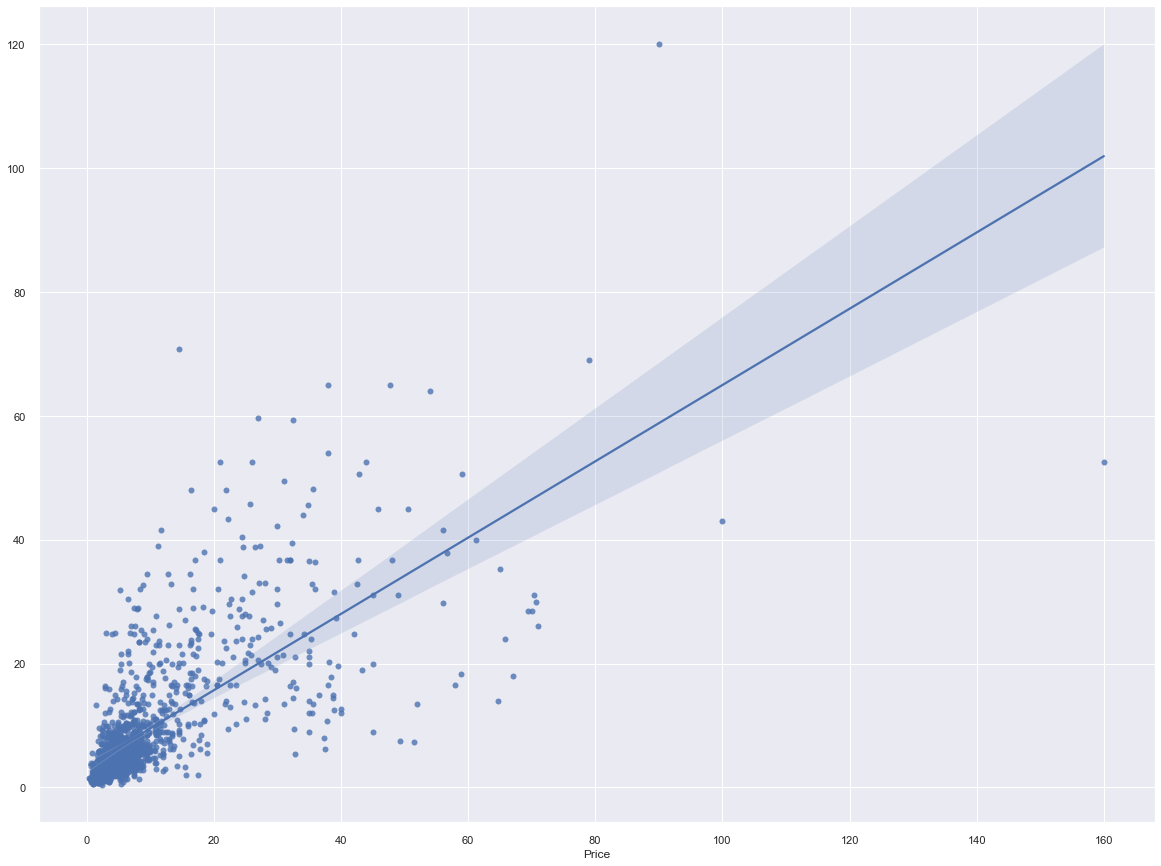

In [76]:
#Decision Tree

dt = DecisionTreeRegressor()

#Train
dt.fit(x_train,y_train)

#Predict

dt_pred = dt.predict(x_test)

# Evaluate
dt_rmse = metrics.mean_squared_error(y_test,dt_pred,squared=False)
dt_R2= metrics.r2_score(y_test,dt_pred)


print('rmse : ', dt_rmse)

print('R2 Score: ', dt_R2)

sns.regplot(x=y_test, y = dt_pred)

rmse :  7.347141789752634
R2 Score:  0.6004289476123443


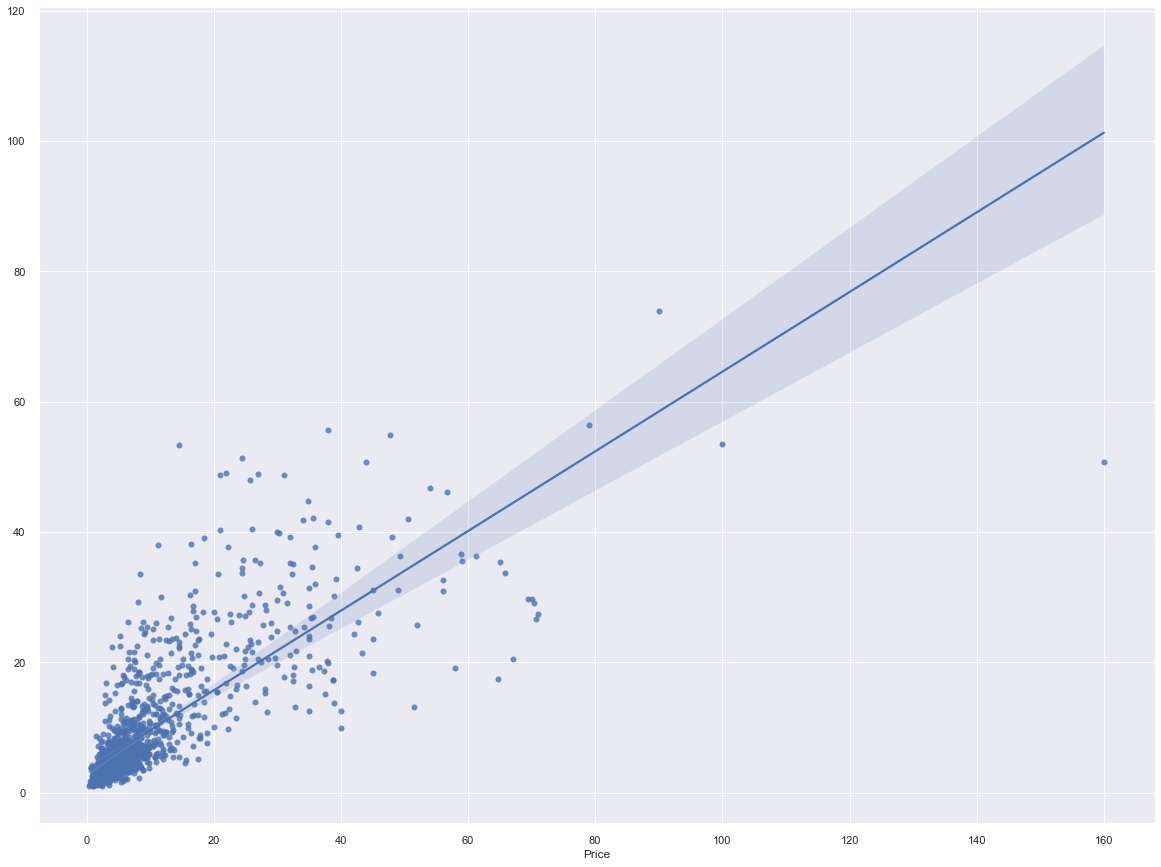

In [77]:
#Random Forest

rf = RandomForestRegressor()

#Train
rf.fit(x_train,y_train)

#Predict

rf_pred = rf.predict(x_test)

# Evaluate
rf_rmse = metrics.mean_squared_error(y_test,rf_pred,squared=False)
rf_R2= metrics.r2_score(y_test,rf_pred)


print('rmse : ', rf_rmse)

print('R2 Score: ', rf_R2)

sns.regplot(x=y_test, y = rf_pred)

rmse :  6.939558390228501
R2 Score:  0.6435317585128351


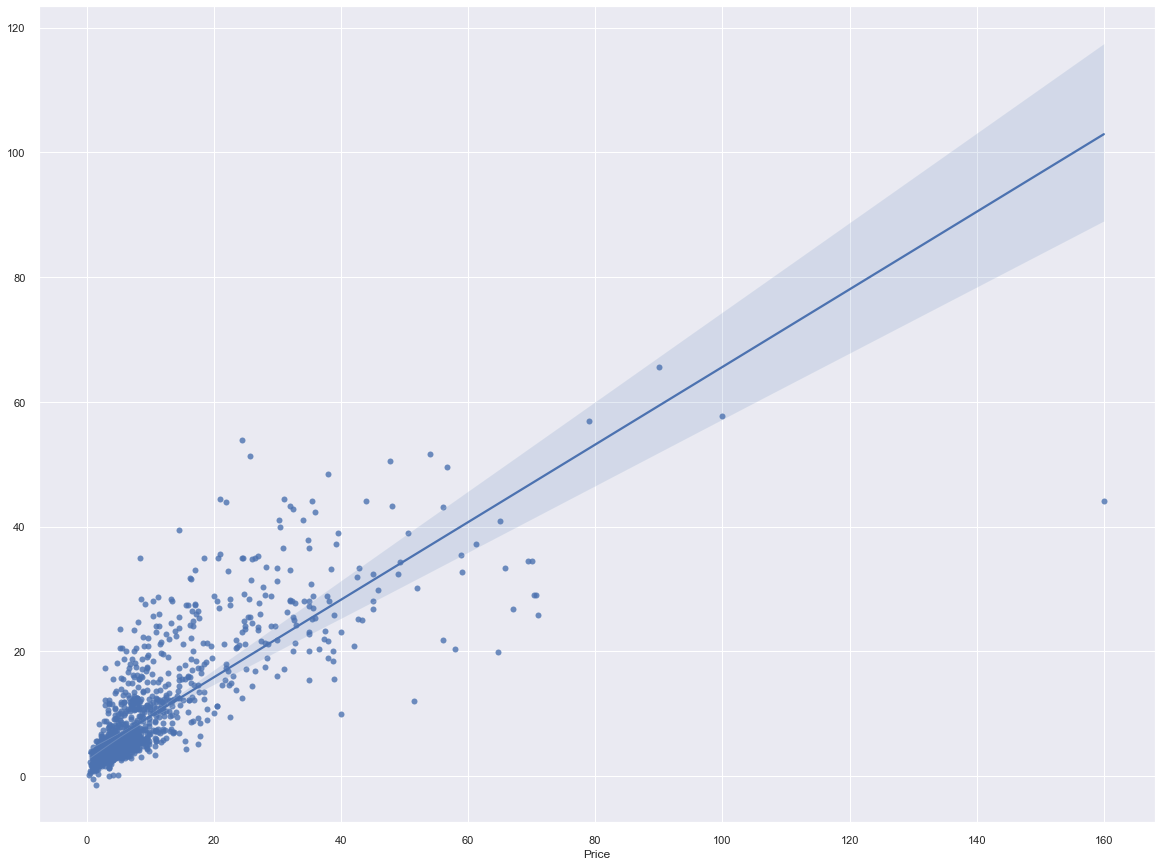

In [78]:
lgbr = lgb.LGBMRegressor()

#Train
lgbr.fit(x_train,y_train)

#Predict

lgbr_pred = lgbr.predict(x_test)

# Evaluate
lgbr_rmse = metrics.mean_squared_error(y_test,lgbr_pred,squared=False)
lgbr_R2= metrics.r2_score(y_test,lgbr_pred)


print('rmse : ', lgbr_rmse)

print('R2 Score: ', lgbr_R2)

sns.regplot(x=y_test, y = lgbr_pred)

0:	learn: 10.8581984	total: 85.5ms	remaining: 1m 25s
1:	learn: 10.6662315	total: 92.1ms	remaining: 46s
2:	learn: 10.4962992	total: 97.2ms	remaining: 32.3s
3:	learn: 10.3207804	total: 102ms	remaining: 25.5s
4:	learn: 10.1523858	total: 107ms	remaining: 21.4s
5:	learn: 9.9902746	total: 112ms	remaining: 18.6s
6:	learn: 9.8361899	total: 117ms	remaining: 16.6s
7:	learn: 9.6741757	total: 122ms	remaining: 15.1s
8:	learn: 9.5279753	total: 127ms	remaining: 13.9s
9:	learn: 9.3875955	total: 131ms	remaining: 13s
10:	learn: 9.2586964	total: 136ms	remaining: 12.2s
11:	learn: 9.1253988	total: 141ms	remaining: 11.6s
12:	learn: 9.0046162	total: 146ms	remaining: 11s
13:	learn: 8.8870538	total: 150ms	remaining: 10.6s
14:	learn: 8.7729371	total: 155ms	remaining: 10.2s
15:	learn: 8.6677817	total: 160ms	remaining: 9.83s
16:	learn: 8.5643005	total: 164ms	remaining: 9.46s
17:	learn: 8.4657044	total: 168ms	remaining: 9.19s
18:	learn: 8.3638404	total: 173ms	remaining: 8.94s
19:	learn: 8.2710377	total: 178ms	rema

166:	learn: 5.8453555	total: 735ms	remaining: 3.67s
167:	learn: 5.8432241	total: 738ms	remaining: 3.66s
168:	learn: 5.8411758	total: 744ms	remaining: 3.66s
169:	learn: 5.8401461	total: 747ms	remaining: 3.65s
170:	learn: 5.8381789	total: 750ms	remaining: 3.64s
171:	learn: 5.8369336	total: 753ms	remaining: 3.62s
172:	learn: 5.8354543	total: 755ms	remaining: 3.61s
173:	learn: 5.8335202	total: 759ms	remaining: 3.6s
174:	learn: 5.8316868	total: 763ms	remaining: 3.6s
175:	learn: 5.8300455	total: 767ms	remaining: 3.59s
176:	learn: 5.8275661	total: 771ms	remaining: 3.58s
177:	learn: 5.8260589	total: 775ms	remaining: 3.58s
178:	learn: 5.8238001	total: 779ms	remaining: 3.57s
179:	learn: 5.8220040	total: 782ms	remaining: 3.56s
180:	learn: 5.8189702	total: 785ms	remaining: 3.55s
181:	learn: 5.8180875	total: 788ms	remaining: 3.54s
182:	learn: 5.8166227	total: 792ms	remaining: 3.54s
183:	learn: 5.8128760	total: 796ms	remaining: 3.53s
184:	learn: 5.8114048	total: 800ms	remaining: 3.52s
185:	learn: 5.

349:	learn: 5.5571755	total: 1.39s	remaining: 2.57s
350:	learn: 5.5568323	total: 1.39s	remaining: 2.57s
351:	learn: 5.5552355	total: 1.39s	remaining: 2.56s
352:	learn: 5.5530980	total: 1.4s	remaining: 2.56s
353:	learn: 5.5513988	total: 1.4s	remaining: 2.55s
354:	learn: 5.5502213	total: 1.4s	remaining: 2.55s
355:	learn: 5.5495450	total: 1.41s	remaining: 2.55s
356:	learn: 5.5476951	total: 1.41s	remaining: 2.54s
357:	learn: 5.5471503	total: 1.42s	remaining: 2.54s
358:	learn: 5.5463191	total: 1.42s	remaining: 2.53s
359:	learn: 5.5452179	total: 1.42s	remaining: 2.53s
360:	learn: 5.5440056	total: 1.43s	remaining: 2.52s
361:	learn: 5.5436605	total: 1.43s	remaining: 2.52s
362:	learn: 5.5423359	total: 1.43s	remaining: 2.51s
363:	learn: 5.5404127	total: 1.43s	remaining: 2.5s
364:	learn: 5.5400539	total: 1.44s	remaining: 2.5s
365:	learn: 5.5383435	total: 1.44s	remaining: 2.5s
366:	learn: 5.5376237	total: 1.44s	remaining: 2.49s
367:	learn: 5.5363925	total: 1.45s	remaining: 2.49s
368:	learn: 5.5355

516:	learn: 5.3974009	total: 2.04s	remaining: 1.9s
517:	learn: 5.3960730	total: 2.04s	remaining: 1.9s
518:	learn: 5.3954881	total: 2.04s	remaining: 1.89s
519:	learn: 5.3934662	total: 2.04s	remaining: 1.89s
520:	learn: 5.3932977	total: 2.05s	remaining: 1.88s
521:	learn: 5.3922793	total: 2.05s	remaining: 1.88s
522:	learn: 5.3918600	total: 2.05s	remaining: 1.87s
523:	learn: 5.3913086	total: 2.06s	remaining: 1.87s
524:	learn: 5.3911030	total: 2.06s	remaining: 1.86s
525:	learn: 5.3905210	total: 2.06s	remaining: 1.86s
526:	learn: 5.3889083	total: 2.06s	remaining: 1.85s
527:	learn: 5.3875769	total: 2.07s	remaining: 1.85s
528:	learn: 5.3871266	total: 2.07s	remaining: 1.84s
529:	learn: 5.3852878	total: 2.08s	remaining: 1.84s
530:	learn: 5.3839057	total: 2.08s	remaining: 1.84s
531:	learn: 5.3819295	total: 2.08s	remaining: 1.83s
532:	learn: 5.3790110	total: 2.09s	remaining: 1.83s
533:	learn: 5.3783795	total: 2.09s	remaining: 1.82s
534:	learn: 5.3778075	total: 2.1s	remaining: 1.82s
535:	learn: 5.3

695:	learn: 5.2393079	total: 2.68s	remaining: 1.17s
696:	learn: 5.2388252	total: 2.69s	remaining: 1.17s
697:	learn: 5.2383517	total: 2.69s	remaining: 1.16s
698:	learn: 5.2372891	total: 2.7s	remaining: 1.16s
699:	learn: 5.2363457	total: 2.7s	remaining: 1.16s
700:	learn: 5.2354478	total: 2.7s	remaining: 1.15s
701:	learn: 5.2342928	total: 2.71s	remaining: 1.15s
702:	learn: 5.2339984	total: 2.71s	remaining: 1.15s
703:	learn: 5.2337420	total: 2.71s	remaining: 1.14s
704:	learn: 5.2333790	total: 2.72s	remaining: 1.14s
705:	learn: 5.2324787	total: 2.72s	remaining: 1.13s
706:	learn: 5.2311628	total: 2.73s	remaining: 1.13s
707:	learn: 5.2303850	total: 2.73s	remaining: 1.13s
708:	learn: 5.2299199	total: 2.73s	remaining: 1.12s
709:	learn: 5.2284416	total: 2.73s	remaining: 1.12s
710:	learn: 5.2274127	total: 2.74s	remaining: 1.11s
711:	learn: 5.2267025	total: 2.74s	remaining: 1.11s
712:	learn: 5.2254295	total: 2.75s	remaining: 1.1s
713:	learn: 5.2251839	total: 2.75s	remaining: 1.1s
714:	learn: 5.224

869:	learn: 5.1061489	total: 3.33s	remaining: 498ms
870:	learn: 5.1058209	total: 3.34s	remaining: 494ms
871:	learn: 5.1052085	total: 3.34s	remaining: 490ms
872:	learn: 5.1048545	total: 3.34s	remaining: 486ms
873:	learn: 5.1040501	total: 3.34s	remaining: 482ms
874:	learn: 5.1037200	total: 3.35s	remaining: 478ms
875:	learn: 5.1028539	total: 3.35s	remaining: 474ms
876:	learn: 5.1021315	total: 3.35s	remaining: 470ms
877:	learn: 5.1017274	total: 3.35s	remaining: 466ms
878:	learn: 5.1010262	total: 3.36s	remaining: 462ms
879:	learn: 5.1001385	total: 3.36s	remaining: 458ms
880:	learn: 5.0992639	total: 3.36s	remaining: 454ms
881:	learn: 5.0989231	total: 3.36s	remaining: 450ms
882:	learn: 5.0988403	total: 3.37s	remaining: 446ms
883:	learn: 5.0985063	total: 3.37s	remaining: 442ms
884:	learn: 5.0977100	total: 3.37s	remaining: 438ms
885:	learn: 5.0974573	total: 3.37s	remaining: 434ms
886:	learn: 5.0956868	total: 3.38s	remaining: 430ms
887:	learn: 5.0950600	total: 3.38s	remaining: 427ms
888:	learn: 

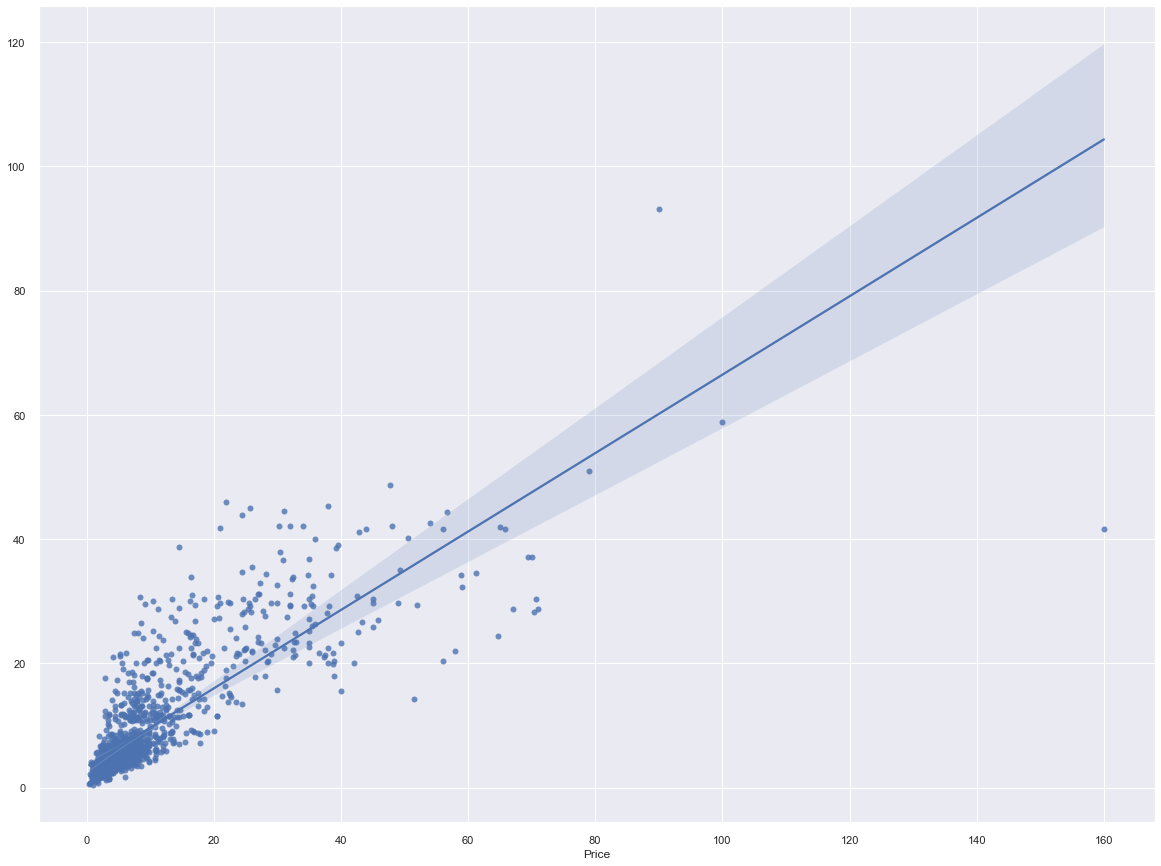

In [79]:
cat = CatBoostRegressor()

#Train
cat.fit(x_train,y_train)

#Predictcat

cat_pred = cat.predict(x_test)

# Evaluate
cat_rmse = metrics.mean_squared_error(y_test,cat_pred,squared=False)
cat_R2= metrics.r2_score(y_test,cat_pred)


print('rmse : ', cat_rmse)

print('R2 Score: ', cat_R2)

sns.regplot(x=y_test, y = cat_pred)